In [1]:
# libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint, randrange

from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import optuna
import joblib
import time, os

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_parquet('../data/cardio_train_correct.parquet').drop('id', axis=1)

X = df.drop('cardio', axis=1)
y = df['cardio']

X

c:\Users\Daniil\Desktop\proj\HSE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,65.238042,1,168.000000,62.0,110,80,0,0,0,0,1
1,49.141256,0,162.229343,85.0,140,90,1,0,0,0,1
2,47.518304,0,165.000000,64.0,130,70,1,0,0,0,0
3,60.669715,1,169.000000,82.0,150,100,0,0,0,0,1
4,60.601698,0,179.251433,56.0,100,60,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,56.682957,1,168.000000,76.0,120,80,0,0,1,0,1
69996,53.547635,0,178.398551,126.0,140,90,1,1,0,0,1
69997,52.991028,1,183.000000,105.0,180,90,1,0,0,1,0
69998,62.603966,0,163.000000,72.0,135,80,0,1,0,0,0


In [2]:
y

0        0
1        1
2        1
3        1
4        0
        ..
69995    0
69996    1
69997    1
69998    1
69999    0
Name: cardio, Length: 70000, dtype: int64

# Новая логика

В текущем вариенте модели представлена новая логика, которая позволит улучшить бейзлайн:
1. Модель кроссвалидации XGBoosting Classifier на 4х фолдах будет заменена на 4 модели, которые представляют собой отдельные фолды с оптимальными гиперпараметрами для каждого.
2. Далее будет собран датасет из 4х скоров по каждой из модели и исходного таргета
3. Для объединения всех скоров будет использован сильный - случайный лес с подобранными гиперпараметрами. Использование слабого классификатора по типу Voting или логистической регрессии нецелесообразно в виду однородности моделей и схожести результатов (разница только в фолдах)


*Примечательно, что для модели не имеет смысла использовать какой-либо отбор факторов в виду и так малого количества признаков на обучении*

In [3]:
def crossval_boosting_optuna(
        X,
        y,
        train_features,
        k_fold_fn,
        param_space,
        out_metrics,
        model_folder='models/',
        save_model_name='XGB_tuned',
        n_folds=4,
        fold_seed=42
):
    # Кросс-валидация (разбиение на фолды)
    k_fold = k_fold_fn(n_split=n_folds, random_state=fold_seed, shuffle=True)

    i = 0
    fold_scores = [[] for _ in range(len(out_metrics))]
    model_list = []

    # numpy array для записи скоров
    y_predicted_train = np.full(shape=(X.shape[0], n_folds), fill_value=-1, dtype=float)

    # Директория для хранения моделей
    os.makedirs(os.path.join(model_folder, save_model_name), exist_ok=True)

    # Обучение на фолдах
    for fold_idx, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        
        i += 1
        time_start_fold = time.time()

        X_train, X_test = (X[train_features].iloc[train_index], X[train_features].iloc[test_index])
        y_train, y_test = (y.iloc[train_index], y.iloc[test_index])

        # Оптимизация гиперпараметров текущего фолда
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'n_jobs': -1,
            }

            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            y_pred = model.predict(X_test)
            score = out_metrics[0](y_test, y_pred)  # кортеж записи метрик на итерации перебора
            return score if isinstance(score, (int, float)) else score[0]   # Возвращаем значение метрики на итерации 

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=20)
        best_params = study.best_params

        # Обучение модели с лучшими параметрами
        model = xgb.XGBClassifier(**best_params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        model_list.append(model)

        # Сохранение модели
        joblib.dump(model, os.path.join(model_folder, save_model_name, f'fold_{i}.pkl'))

        # Прогнозы OOF
        y_prob_fold = model.predict_proba(X[train_features])[:, 1]  # Делаем прогноз по всей выборки всеми моделями и формируем матрицу
        y_predicted_train[:, fold_idx] = y_prob_fold

        y_pred_fold = model.predict(X_test)

        # Метрики
        for j, metric in enumerate(out_metrics):
            score = round(metric(y_test, y_pred_fold), 5)
            fold_scores[j].append(score)
            print(f'{i} it: {score} Metric-{j} time: {round(time.time() - time_start_fold)}')

    return {
        'train_oof': y_predicted_train,
        'model_list': model_list,
        **{f'fold_score_list_{j+1}': fold_scores[j] for j in range(len(out_metrics))}
    }

In [4]:
train_features = X.columns.tolist()

# Функция разбиения на фолды
def k_fold_fn(n_split=4, random_state=42, shuffle=True):
    return StratifiedKFold(n_splits=n_split, random_state=random_state, shuffle=shuffle)

# Метрики для оценки модели
out_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score]

# Запуск кросс-валидации c тюнингом
results = crossval_boosting_optuna(
    X, y, train_features, k_fold_fn, {}, out_metrics
)

# Вывод результатов
print("OOF Predictions:", results['train_oof'])
for i, scores in enumerate(results.values()):
    if i > 1:  # Пропустить OOF и model_list
        print(f'Metric {i-1}: {scores}')


[I 2025-03-15 16:30:06,160] A new study created in memory with name: no-name-6c0710ad-dc27-4d09-aacf-32b2f76b2eb8


[I 2025-03-15 16:30:08,141] Trial 0 finished with value: 0.6837142857142857 and parameters: {'n_estimators': 606, 'learning_rate': 0.4595924134207985, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8741554978239239, 'colsample_bytree': 0.6220642872099695}. Best is trial 0 with value: 0.6837142857142857.
[I 2025-03-15 16:30:08,496] Trial 1 finished with value: 0.7398285714285714 and parameters: {'n_estimators': 141, 'learning_rate': 0.05250916477655081, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5192299293949869, 'colsample_bytree': 0.5905103180748799}. Best is trial 1 with value: 0.7398285714285714.
[I 2025-03-15 16:30:10,788] Trial 2 finished with value: 0.6799428571428572 and parameters: {'n_estimators': 580, 'learning_rate': 0.42542524081936434, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.6493073886825509, 'colsample_bytree': 0.6229069151009105}. Best is trial 1 with value: 0.7398285714285714.
[I 2025-03-15 16:30:12,244] Trial 3 finished with value: 0.72

[0]	validation_0-logloss:0.67982
[1]	validation_0-logloss:0.67556
[2]	validation_0-logloss:0.66460
[3]	validation_0-logloss:0.65962
[4]	validation_0-logloss:0.65715
[5]	validation_0-logloss:0.65408
[6]	validation_0-logloss:0.64534
[7]	validation_0-logloss:0.63824
[8]	validation_0-logloss:0.63367
[9]	validation_0-logloss:0.62553
[10]	validation_0-logloss:0.61989
[11]	validation_0-logloss:0.61549
[12]	validation_0-logloss:0.60916
[13]	validation_0-logloss:0.60755
[14]	validation_0-logloss:0.60446
[15]	validation_0-logloss:0.59936
[16]	validation_0-logloss:0.59401
[17]	validation_0-logloss:0.59111
[18]	validation_0-logloss:0.58655
[19]	validation_0-logloss:0.58288
[20]	validation_0-logloss:0.58139
[21]	validation_0-logloss:0.58009
[22]	validation_0-logloss:0.57671
[23]	validation_0-logloss:0.57455
[24]	validation_0-logloss:0.57279
[25]	validation_0-logloss:0.56999
[26]	validation_0-logloss:0.56745
[27]	validation_0-logloss:0.56613
[28]	validation_0-logloss:0.56522
[29]	validation_0-loglos

[I 2025-03-15 16:30:28,383] A new study created in memory with name: no-name-c5943629-82ba-4103-859c-a67a5f996f89
[I 2025-03-15 16:30:29,181] Trial 0 finished with value: 0.7205142857142857 and parameters: {'n_estimators': 271, 'learning_rate': 0.2979814466363085, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9526797800842524, 'colsample_bytree': 0.6219129750797063}. Best is trial 0 with value: 0.7205142857142857.
[I 2025-03-15 16:30:31,002] Trial 1 finished with value: 0.7228 and parameters: {'n_estimators': 853, 'learning_rate': 0.35732345123574283, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5152093497466181, 'colsample_bytree': 0.7284649432230189}. Best is trial 1 with value: 0.7228.
[I 2025-03-15 16:30:31,961] Trial 2 finished with value: 0.7190285714285715 and parameters: {'n_estimators': 326, 'learning_rate': 0.24027175719623994, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7421083938926769, 'colsample_bytree': 0.8368730676994021}. Best is trial 1 with

[0]	validation_0-logloss:0.65415
[1]	validation_0-logloss:0.63126
[2]	validation_0-logloss:0.60767
[3]	validation_0-logloss:0.60001
[4]	validation_0-logloss:0.58931
[5]	validation_0-logloss:0.58504
[6]	validation_0-logloss:0.57303
[7]	validation_0-logloss:0.56424
[8]	validation_0-logloss:0.55803
[9]	validation_0-logloss:0.55307
[10]	validation_0-logloss:0.55078
[11]	validation_0-logloss:0.54902
[12]	validation_0-logloss:0.54617
[13]	validation_0-logloss:0.54566
[14]	validation_0-logloss:0.54501
[15]	validation_0-logloss:0.54325
[16]	validation_0-logloss:0.54175
[17]	validation_0-logloss:0.54042
[18]	validation_0-logloss:0.53943
[19]	validation_0-logloss:0.53871
[20]	validation_0-logloss:0.53840
[21]	validation_0-logloss:0.53780
[22]	validation_0-logloss:0.53723
[23]	validation_0-logloss:0.53688
[24]	validation_0-logloss:0.53664
[25]	validation_0-logloss:0.53628
[26]	validation_0-logloss:0.53609
[27]	validation_0-logloss:0.53592
[28]	validation_0-logloss:0.53584
[29]	validation_0-loglos

[I 2025-03-15 16:30:50,185] A new study created in memory with name: no-name-ec5fe419-98b2-4180-a379-4d4836d1f91d
[I 2025-03-15 16:30:50,867] Trial 0 finished with value: 0.7401714285714286 and parameters: {'n_estimators': 355, 'learning_rate': 0.22204144585666455, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8053999613661518, 'colsample_bytree': 0.5280707095775521}. Best is trial 0 with value: 0.7401714285714286.
[I 2025-03-15 16:30:54,688] Trial 1 finished with value: 0.6669142857142857 and parameters: {'n_estimators': 957, 'learning_rate': 0.4888134566894439, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.615615041937563, 'colsample_bytree': 0.8295273183625393}. Best is trial 0 with value: 0.7401714285714286.
[I 2025-03-15 16:30:55,095] Trial 2 finished with value: 0.7428 and parameters: {'n_estimators': 199, 'learning_rate': 0.42837620852262726, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6736797335699161, 'colsample_bytree': 0.6647190486012807}. Best is 

[0]	validation_0-logloss:0.60673
[1]	validation_0-logloss:0.58027
[2]	validation_0-logloss:0.55747
[3]	validation_0-logloss:0.55045
[4]	validation_0-logloss:0.54732
[5]	validation_0-logloss:0.54524
[6]	validation_0-logloss:0.53938
[7]	validation_0-logloss:0.53642
[8]	validation_0-logloss:0.53513
[9]	validation_0-logloss:0.53410
[10]	validation_0-logloss:0.53315
[11]	validation_0-logloss:0.53264
[12]	validation_0-logloss:0.53224
[13]	validation_0-logloss:0.53197
[14]	validation_0-logloss:0.53191
[15]	validation_0-logloss:0.53151
[16]	validation_0-logloss:0.53112
[17]	validation_0-logloss:0.53087
[18]	validation_0-logloss:0.53052
[19]	validation_0-logloss:0.53048
[20]	validation_0-logloss:0.53051
[21]	validation_0-logloss:0.53041
[22]	validation_0-logloss:0.53020
[23]	validation_0-logloss:0.53031
[24]	validation_0-logloss:0.53030
[25]	validation_0-logloss:0.53031
[26]	validation_0-logloss:0.53008
[27]	validation_0-logloss:0.53022
[28]	validation_0-logloss:0.53029
[29]	validation_0-loglos

[I 2025-03-15 16:31:11,496] A new study created in memory with name: no-name-20d97701-11d0-4da6-87a1-37c007a1b074
[I 2025-03-15 16:31:15,012] Trial 0 finished with value: 0.7010857142857143 and parameters: {'n_estimators': 961, 'learning_rate': 0.11039179529412595, 'max_depth': 12, 'min_child_weight': 10, 'subsample': 0.7860746093049187, 'colsample_bytree': 0.9852793597324006}. Best is trial 0 with value: 0.7010857142857143.
[I 2025-03-15 16:31:17,590] Trial 1 finished with value: 0.6880571428571428 and parameters: {'n_estimators': 768, 'learning_rate': 0.32632979871283596, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.9952359896320802, 'colsample_bytree': 0.585876055112404}. Best is trial 0 with value: 0.7010857142857143.
[I 2025-03-15 16:31:17,722] Trial 2 finished with value: 0.7392571428571428 and parameters: {'n_estimators': 50, 'learning_rate': 0.35130281469037095, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5218906204926828, 'colsample_bytree': 0.7386940249211

[0]	validation_0-logloss:0.62182
[1]	validation_0-logloss:0.59420
[2]	validation_0-logloss:0.57148
[3]	validation_0-logloss:0.56491
[4]	validation_0-logloss:0.55874
[5]	validation_0-logloss:0.55582
[6]	validation_0-logloss:0.54899
[7]	validation_0-logloss:0.54534
[8]	validation_0-logloss:0.54327
[9]	validation_0-logloss:0.54196
[10]	validation_0-logloss:0.54062
[11]	validation_0-logloss:0.53995
[12]	validation_0-logloss:0.53899
[13]	validation_0-logloss:0.53874
[14]	validation_0-logloss:0.53864
[15]	validation_0-logloss:0.53836
[16]	validation_0-logloss:0.53788
[17]	validation_0-logloss:0.53746
[18]	validation_0-logloss:0.53723
[19]	validation_0-logloss:0.53704
[20]	validation_0-logloss:0.53692
[21]	validation_0-logloss:0.53681
[22]	validation_0-logloss:0.53676
[23]	validation_0-logloss:0.53651
[24]	validation_0-logloss:0.53622
[25]	validation_0-logloss:0.53607
[26]	validation_0-logloss:0.53606
[27]	validation_0-logloss:0.53611
[28]	validation_0-logloss:0.53607
[29]	validation_0-loglos

Теперь соберём новый датасет, состоящий из скоров от моделей на 4х фолдах и исходным таргетом cardio и на его основе построем случайный лес. На этот раз для разнообразия переберём гиперпараметры методов GridSearchCV:

In [5]:
df_res = pd.DataFrame(results['train_oof'], columns=[f'fold_{i}' for i in range(1,5)])
df_res['cardio'] = df['cardio']
df_res

,fold_1,fold_2,fold_3,fold_4,cardio
0,0.148928,0.174050,0.160893,0.156125,0
1,0.880998,0.884603,0.912006,0.887386,1
2,0.700175,0.739575,0.804632,0.792975,1
3,0.806236,0.816910,0.847372,0.811636,1
4,0.090628,0.094306,0.114567,0.125040,0
...,...,...,...,...,...
69995,0.214082,0.215322,0.245303,0.220022,0
69996,0.747969,0.784896,0.871174,0.790744,1
69997,0.891556,0.905384,0.950893,0.870606,1
69998,0.514451,0.531523,0.449412,0.611246,1


In [6]:
X_score = df_res.drop('cardio', axis=1)
y_score = df_res['cardio']
X_score

,fold_1,fold_2,fold_3,fold_4
0,0.148928,0.174050,0.160893,0.156125
1,0.880998,0.884603,0.912006,0.887386
2,0.700175,0.739575,0.804632,0.792975
3,0.806236,0.816910,0.847372,0.811636
4,0.090628,0.094306,0.114567,0.125040
...,...,...,...,...
69995,0.214082,0.215322,0.245303,0.220022
69996,0.747969,0.784896,0.871174,0.790744
69997,0.891556,0.905384,0.950893,0.870606
69998,0.514451,0.531523,0.449412,0.611246


In [7]:
y_score

0        0
1        1
2        1
3        1
4        0
        ..
69995    0
69996    1
69997    1
69998    1
69999    0
Name: cardio, Length: 70000, dtype: int64

In [8]:
# Ансамбль случайного леса
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

param_grid = {
    'n_estimators': range(50, 351, 100),
    'max_depth': range(4, 9, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': range(1, 6, 2),
    'max_features': ['sqrt'],
    'bootstrap': [True],
}

RF_CV = GridSearchCV(RandomForestClassifier(random_state=120), param_grid, 
                     scoring=roc_auc_scorer, n_jobs=-1)

RF_CV.fit(X_score, y_score)

enc_pred = RF_CV.predict(X_score)
enc_prob = RF_CV.predict_proba(X_score)[:,1]

enc_acc = accuracy_score(df_res['cardio'], enc_pred)
enc_prec = precision_score(df_res['cardio'], enc_pred)
enc_rec = recall_score(df_res['cardio'], enc_pred)
enc_f1 = f1_score(df_res['cardio'], enc_pred)
enc_auc = roc_auc_score(df_res['cardio'], enc_prob)
enc_kappa = cohen_kappa_score(df_res['cardio'], enc_pred)

Results = pd.DataFrame({
                            'Algorithm': 'Random Forest Classifier',
                            'Accuracy': enc_acc,
                            'Precision': enc_prec,
                            'Recall': enc_rec,
                            'F1': enc_f1,
                            'ROC-AUC': enc_auc,
                            'Cohen-Kappa': enc_kappa
                        }, index=[0])

Results

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,Cohen-Kappa
0,Random Forest Classifier,0.747243,0.770923,0.703108,0.735456,0.816764,0.494459


In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay, confusion_matrix

Сравнение с базовыми моделями:

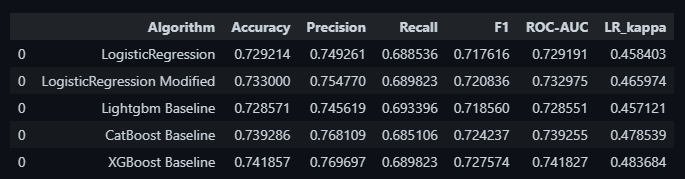

<Axes: >

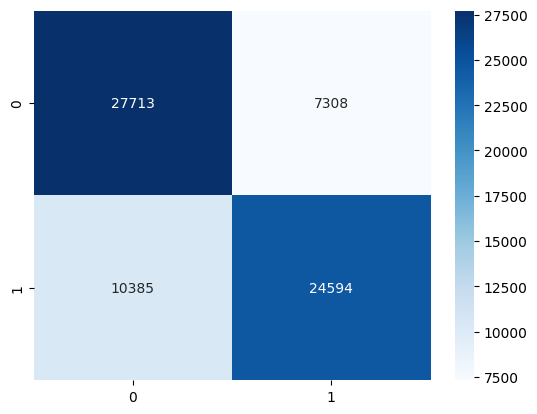

In [10]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_score, enc_pred)
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd')

Удалось значительно повысить качество модели путём отдельной обработки каждого фолда и соединения в кастомный ансамбль

In [11]:
joblib.dump(RF_CV, '../models/rf_encemble.pkl')

['../models/rf_encemble.pkl']

In [12]:
# Проверка модели на адекватность
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(strategy = 'most_frequent', random_state = 42)
dummy_model.fit(X_score, y_score)
dummy_model.predict(X_score)
dummy_model.score(X_score, y_score)

0.5003

Значение дамми-классификатора говорит о сбалансированности классов и отсутствии необходимости менять трэшхолды. Следовательно, текущую модель можно признать адекватной.